In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from external.cmiknnmixed.cmiknnmixed import CMIknnMixed
from external.cmiknnmixed.experiments.estimation.simulations import *
import pybnesian as pbn
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import timeit
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.special import gammaln, expit

/home/juan/miniconda3/envs/pcspbn/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    os.mkdir('./results/')
except:
    pass

try:
    os.mkdir('./results/synthetic/')
except:
    pass

In [3]:
def generate_Z(N, Dz, cont_discrete_ratio=0.5, num_categories=5, seed=None):
    rng = np.random.default_rng(seed)
    D_cont = int(Dz * cont_discrete_ratio)
    D_disc = Dz - D_cont

    Z_cont = rng.standard_normal((N, D_cont))

    Z_disc = np.zeros((N, D_disc), dtype=int)
    for d in range(D_disc):
        probs = rng.dirichlet(np.ones(num_categories))
        Z_disc[:, d] = rng.choice(num_categories, size=N, p=probs)

    return Z_cont, Z_disc

def generate_experiment_unconditionally_dependent(N=1000, Dz=6, cont_discrete_ratio=0.5, m=5, seed=None):
    rng = np.random.default_rng(seed)

    # X ~ Uniform{0, ..., m-1}
    X = rng.integers(0, m, size=N)

    # Y ~ Uniform(X, X+2)
    Y = rng.uniform(X, X + 2.0)

    # Z as before (conditionally independent from X, Y)
    Z_cont, Z_disc = generate_Z(N, Dz, cont_discrete_ratio, seed=seed)

    return X, Y, Z_cont, Z_disc


#### Empirical complexity with the sample size

In [ ]:
n_trials = 400
timings_pbn = []
timings_tgm = []
tgm_cmi = CMIknnMixed(knn=0.3, estimator='MSinf', transform='ranks', knn_type='local')

for seed, num_samples in tenumerate(range(200, 2001, 100)):
    X, Y, Z_cont, Z_disc = generate_experiment_unconditionally_dependent(num_samples, 2, 0.5, 5, seed=seed + 42)
    df = pd.DataFrame([X, Y] + Z_cont.T.tolist() + Z_disc.T.tolist()).T
    for i in range(len(df.columns)):
        if i == 0 or i > (len(df.columns) - 2) // 2 + 1:
            df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
    x = str(df.columns[0])
    y = str(df.columns[1])
    z = [str(x) for x in df.columns[2:]]
    categorical_df = df.select_dtypes(include=['category'])
    # Count frequency of each unique configuration
    min_cluster_size = categorical_df.value_counts().min()


    pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=max(1, int(min_cluster_size*0.3)), scaling="normalized_rank", adaptive_k=True)
    time_pbn = timeit.repeat('pbn_knncmi.mi(x, y, z)', repeat=1, number=n_trials, globals=globals())
    timings_pbn.append(time_pbn)

    for i in range(len(df.columns)):
        if i == 0 or i > (len(df.columns) - 2) // 2 + 1:
            df.iloc[:, i] = df.iloc[:, i].cat.codes.astype(np.int64)
    array = df.values.T
    data_type=np.repeat(np.array([1* (df.dtypes== 'int64')]).T, len(df), axis=1)
    xyz=np.array([0, 1] + [2]*(len(df.columns) - 2))
    
    time_tgm = timeit.repeat('tgm_cmi.get_dependence_measure(array=array, xyz=xyz, data_type=data_type)', repeat=1, number=n_trials, globals=globals())
    timings_tgm.append(time_tgm)

100%|██████████| 19/19 [02:22<00:00,  7.52s/it]


In [6]:
nlogn = [i * np.log2(i) for i in range(200, 2001, 100)]

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2109949/1192372485.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.axhline(y= np.max(np.mean(timings_pbn[8:], axis=1)/nlogn[8:]), color='gray', linestyle='--', label = '$\lambda_u^{PBN}$')
/tmp/ipykernel_2109949/1192372485.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.axhline(y= np.max(np.mean(timings_tgm[8:], axis=1)/nlogn[8:]), color='pink', linestyle='--', label = '$\lambda_u^{TGM}$')
/tmp/ipykernel_2109949/1192372485.py:8: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Time (s) / N \cdot log_{2}(N)$")


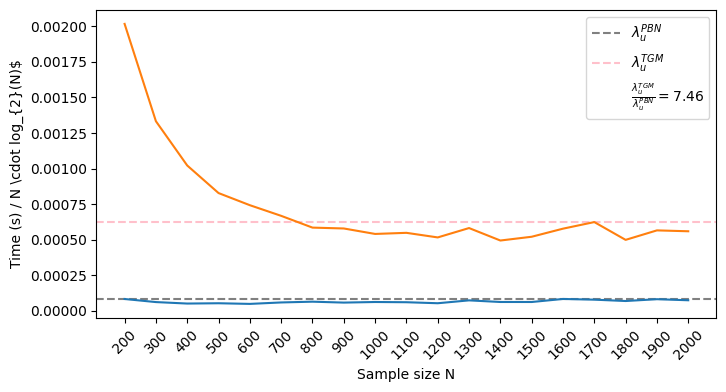

In [7]:
plt.figure(figsize=(8, 4))
plt.axhline(y= np.max(np.mean(timings_pbn[8:], axis=1)/nlogn[8:]), color='gray', linestyle='--', label = '$\lambda_u^{PBN}$')
plt.axhline(y= np.max(np.mean(timings_tgm[8:], axis=1)/nlogn[8:]), color='pink', linestyle='--', label = '$\lambda_u^{TGM}$')
sns.lineplot(np.mean(timings_pbn, axis=1)/nlogn)
sns.lineplot(np.mean(timings_tgm, axis=1)/nlogn)
plt.xticks(ticks= [i for i,_ in enumerate(range(200, 2001, 100))], labels=[i for i in range(200, 2001, 100)], rotation=45)
plt.xlabel("Sample size N")
plt.ylabel("Time (s) / N \cdot log_{2}(N)$")


# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch(label=r'$\frac{\lambda_u^{TGM}}{\lambda_u^{PBN}} =$' + f'{np.max(np.mean(timings_tgm[8:], axis=1)/nlogn[8:])/np.max(np.mean(timings_pbn[8:], axis=1)/nlogn[8:]):.2f}', color='none', linewidth=0.1)

# handles is a list, so append manual patch
handles.append(patch)
plt.legend(handles=handles) 

In [8]:
np.mean(timings_pbn, axis=1)[::2]/n_trials

array([0.0003189 , 0.00044486, 0.00067868, 0.00124584, 0.00155269,
       0.00164696, 0.00228376, 0.00356205, 0.00337157, 0.00408771])

In [9]:
np.mean(timings_tgm, axis=1)[::2]/n_trials

array([0.00770446, 0.00882693, 0.01027623, 0.01128106, 0.01346385,
       0.01583284, 0.01807801, 0.02458603, 0.02427416, 0.03065947])

In [10]:
[np.mean(timings_tgm, axis=1)/np.mean(timings_pbn, axis=1)][0][::2]

array([24.15940383, 19.8419344 , 15.14152182,  9.05499553,  8.67131529,
        9.61334672,  7.91588382,  6.9022225 ,  7.19964915,  7.50040918])

#### Empirical complexity with the dimensionality of Z

In [11]:
n_trials = 50
timings_pbn = []
timings_tgm = []
tgm_cmi = CMIknnMixed(knn=0.3, estimator='MSinf', transform='ranks', knn_type='local')

for seed, z_dims in tenumerate(range(0, 14, 1)):
    X, Y, Z_cont, Z_disc = generate_experiment_unconditionally_dependent(1000, z_dims, 0.5, 5, seed=seed + 42)
    df = pd.DataFrame([X, Y] + Z_cont.T.tolist() + Z_disc.T.tolist()).T
    for i in range(len(df.columns)):
        if i == 0 or i > (len(df.columns) - 2) // 2 + 1:
            df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
    x = str(df.columns[0])
    y = str(df.columns[1])
    z = [str(x) for x in df.columns[2:]]
    categorical_df = df.select_dtypes(include=['category'])

    # Count frequency of each unique configuration
    min_cluster_size = categorical_df.value_counts().min()


    pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=max(1, int(min_cluster_size*0.3)), scaling="normalized_rank", adaptive_k=True)
    time_pbn = timeit.repeat('pbn_knncmi.mi(x, y, z)', repeat=1, number=n_trials, globals=globals())
    timings_pbn.append(time_pbn)

    for i in range(len(df.columns)):
        if i == 0 or i > (len(df.columns) - 2) // 2 + 1:
            df.iloc[:, i] = df.iloc[:, i].cat.codes.astype(np.int64)
    array = df.values.T
    data_type=np.repeat(np.array([1* (df.dtypes== 'int64')]).T, len(df), axis=1)
    xyz=np.array([0, 1] + [2]*(len(df.columns) - 2))
    
    time_tgm = timeit.repeat('tgm_cmi.get_dependence_measure(array=array, xyz=xyz, data_type=data_type)', repeat=1, number=n_trials, globals=globals())
    timings_tgm.append(time_tgm)

100%|██████████| 14/14 [07:59<00:00, 34.28s/it] 


In [12]:
# n = [np.pow(5, i) * 1000//20 * (1000) * np.log2(1000) for i in range(0, 16, 1)]
n = [(2 + i) * 1000//20 * (1000) * np.log2(1000) for i in range(0, 14, 1)]

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2109949/3228927595.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.axhline(y= np.max(np.mean(timings_pbn[8:], axis=1)/n[8:]), color='gray', linestyle='--', label = '$\lambda_u^{PBN}$')
/tmp/ipykernel_2109949/3228927595.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.axhline(y= np.max(np.mean(timings_tgm[8:], axis=1)/n[8:]), color='pink', linestyle='--', label = '$\lambda_u^{TGM}$')


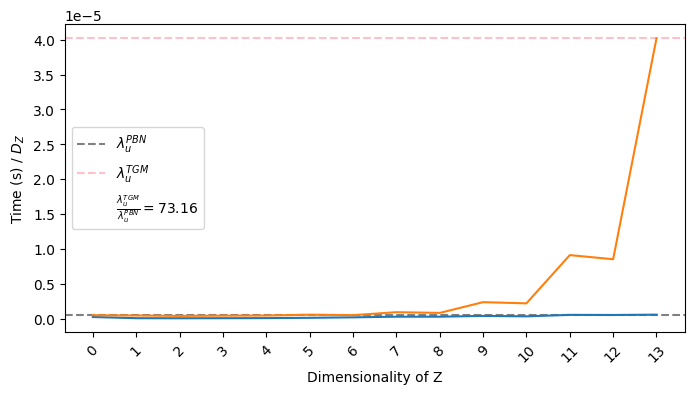

In [13]:
plt.figure(figsize=(8, 4))
plt.axhline(y= np.max(np.mean(timings_pbn[8:], axis=1)/n[8:]), color='gray', linestyle='--', label = '$\lambda_u^{PBN}$')
plt.axhline(y= np.max(np.mean(timings_tgm[8:], axis=1)/n[8:]), color='pink', linestyle='--', label = '$\lambda_u^{TGM}$')
sns.lineplot(np.mean(timings_pbn, axis=1)/n)
sns.lineplot(np.mean(timings_tgm, axis=1)/n)
plt.xticks(ticks= [i for i,_ in enumerate(range(0, 14, 1))], labels=[i for i in range(0, 14, 1)], rotation=45)
plt.xlabel("Dimensionality of Z")
plt.ylabel("Time (s) / $D_Z$")


# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch(label=r'$\frac{\lambda_u^{TGM}}{\lambda_u^{PBN}} =$' + f'{np.max(np.mean(timings_tgm[4:], axis=1)/n[4:])/np.max(np.mean(timings_pbn[4:], axis=1)/n[4:]):.2f}', color='none', linewidth=0.1)

# handles is a list, so append manual patch
handles.append(patch)
plt.legend(handles=handles) 

In [14]:
np.mean(timings_pbn, axis=1)[[0, 1, 2, 3, 5, 7, 9, 11, 12, 13]]/n_trials

array([0.00427413, 0.00133498, 0.00133522, 0.00225633, 0.00686198,
       0.02327205, 0.04069105, 0.06759849, 0.07024943, 0.08214745])

In [15]:
np.mean(timings_tgm, axis=1)[[0, 1, 2, 3, 5, 7, 9, 11, 12, 13]]/n_trials

array([0.00931921, 0.0130185 , 0.01473519, 0.0205439 , 0.03827676,
       0.0812205 , 0.25711778, 1.17838649, 1.18633492, 6.00991022])

In [16]:
[np.mean(timings_tgm, axis=1)/np.mean(timings_pbn, axis=1)][0][[0, 1, 2, 3, 5, 7, 9, 11, 12, 13]]

array([ 2.18037581,  9.75182265, 11.03575079,  9.10499315,  5.57809567,
        3.49004512,  6.318779  , 17.43214239, 16.88746771, 73.16003478])

### Distribution of CMI estimates for different setups

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_200189/3576778975.py:44: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
/tmp/ipykernel_200189/3576778975.py:45: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
100%|██████████| 4/4 [00:32<00:00,  8.04s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


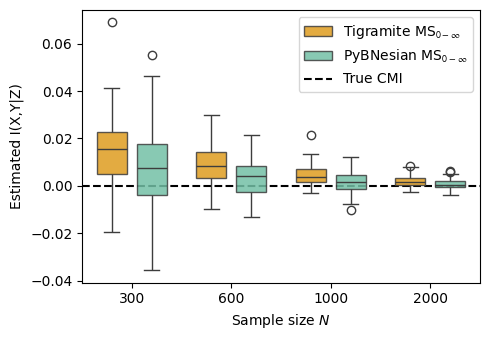

In [4]:
n_trials = 100
mi_pbn = []
mi_tgm = []
tgm_cmi = CMIknnMixed(knn=0.1, estimator='MSinf', transform='ranks', knn_type='local')

for seed, num_samples in tenumerate([300, 600, 1000, 2000]):
    acc_pbn = []
    acc_tgm = []
    for _ in range(n_trials):
        df, type_array, info, name, xyz = confounder(n=num_samples)
        for i in range(len(df.columns)):
            if i == 2:
                df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
        x = str(df.columns[0])
        y = str(df.columns[1])
        z = [str(x) for x in df.columns[2:]]
        categorical_df = df.select_dtypes(include=['category'])

        # Count frequency of each unique configuration
        min_cluster_size = categorical_df.value_counts().min()


        pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=max(1, int(min_cluster_size*0.1)), scaling="normalized_rank", adaptive_k=True)
        acc_pbn.append(pbn_knncmi.mi(x, y, z))

        for i in range(len(df.columns)):
            if i == 2:
                df.iloc[:, i] = df.iloc[:, i].cat.codes.astype(np.int64)
        array = df.values.T
        data_type=np.repeat(np.array([1* (df.dtypes== 'int64')]).T, len(df), axis=1)
        xyz=np.array([0, 1] + [2]*(len(df.columns) - 2))
     
        acc_tgm.append(tgm_cmi.get_dependence_measure(array=array, xyz=xyz, data_type=data_type))
    mi_pbn.append(acc_pbn)
    mi_tgm.append(acc_tgm)

num_groups = len(mi_tgm)
positions_tgm = np.arange(num_groups) - 0.2
positions_pbn = np.arange(num_groups) + 0.2

plt.figure(figsize=(5, 3.5))

# Plot each group side by side
sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
plt.axhline(y=info, color='black', linestyle='--', label = 'True CMI', zorder=-1)

plt.xlabel("Sample size $N$", fontsize=10)
plt.ylabel("Estimated I(X,Y|Z)", fontsize=10)
plt.xticks(np.arange(num_groups), [300, 600, 1000, 2000])
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('./results/synthetic/CMI1.eps', format='eps', bbox_inches='tight')

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_200189/3884502183.py:44: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
/tmp/ipykernel_200189/3884502183.py:45: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
100%|██████████| 4/4 [00:26<00:00,  6.58s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


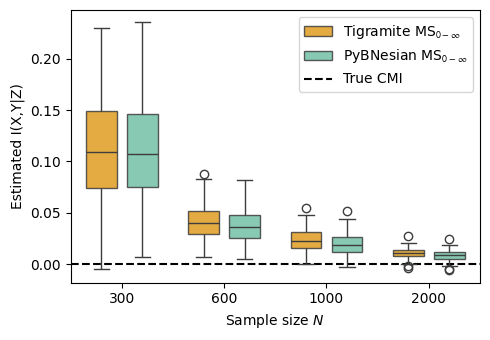

In [5]:
n_trials = 100
mi_pbn = []
mi_tgm = []
tgm_cmi = CMIknnMixed(knn=0.1, estimator='MSinf', transform='ranks', knn_type='local')

for seed, num_samples in tenumerate([300, 600, 1000, 2000]):
    acc_pbn = []
    acc_tgm = []
    for _ in range(n_trials):
        df, type_array, info, name, xyz = run_confounder_normal_ZMADG(n=num_samples)
        for i in range(len(df.columns)):
            if i == 2:
                df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
        x = str(df.columns[0])
        y = str(df.columns[1])
        z = [str(x) for x in df.columns[2:]]
        categorical_df = df.select_dtypes(include=['category'])

        # Count frequency of each unique configuration
        min_cluster_size = categorical_df.value_counts().min()


        pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=max(1, int(min_cluster_size*0.1)), scaling="normalized_rank", adaptive_k=True)
        acc_pbn.append(pbn_knncmi.mi(x, y, z))

        for i in range(len(df.columns)):
            if i == 2:
                df.iloc[:, i] = df.iloc[:, i].cat.codes.astype(np.int64)
        array = df.values.T
        data_type=np.repeat(np.array([1* (df.dtypes== 'int64')]).T, len(df), axis=1)
        xyz=np.array([0, 1] + [2]*(len(df.columns) - 2))
     
        acc_tgm.append(tgm_cmi.get_dependence_measure(array=array, xyz=xyz, data_type=data_type))
    mi_pbn.append(acc_pbn)
    mi_tgm.append(acc_tgm)

num_groups = len(mi_tgm)
positions_tgm = np.arange(num_groups) - 0.2
positions_pbn = np.arange(num_groups) + 0.2

plt.figure(figsize=(5, 3.5))

# Plot each group side by side
sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
plt.axhline(y=info, color='black', linestyle='--', label = 'True CMI', zorder=-1)

plt.xlabel("Sample size $N$", fontsize=10)
plt.ylabel("Estimated I(X,Y|Z)", fontsize=10)
plt.xticks(np.arange(num_groups), [300, 600, 1000, 2000])
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('./results/synthetic/CMI2.eps', format='eps', bbox_inches='tight')

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_200189/2272156839.py:44: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
/tmp/ipykernel_200189/2272156839.py:45: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
100%|██████████| 4/4 [00:19<00:00,  4.88s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


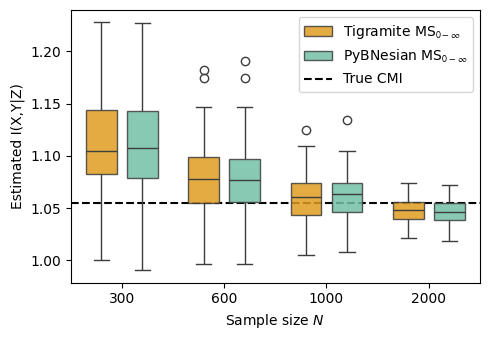

In [6]:
n_trials = 100
mi_pbn = []
mi_tgm = []
tgm_cmi = CMIknnMixed(knn=0.1, estimator='MSinf', transform='ranks', knn_type='local')

for seed, num_samples in tenumerate([300, 600, 1000, 2000]):
    acc_pbn = []
    acc_tgm = []
    for _ in range(n_trials):
        df, type_array, info, name, xyz = run_corrUnif_ZMADG_nd_Ber(n=num_samples)
        for i in range(len(df.columns)):
            if i != 1:
                df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
        x = str(df.columns[0])
        y = str(df.columns[1])
        z = [str(x) for x in df.columns[2:]]
        categorical_df = df.select_dtypes(include=['category'])

        # Count frequency of each unique configuration
        min_cluster_size = categorical_df.value_counts().min()


        pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=max(1, int(min_cluster_size*0.1)), scaling="normalized_rank", adaptive_k=True)
        acc_pbn.append(pbn_knncmi.mi(x, y, z))

        for i in range(len(df.columns)):
            if i != 1:
                df.iloc[:, i] = df.iloc[:, i].cat.codes.astype(np.int64)
        array = df.values.T
        data_type=np.repeat(np.array([1* (df.dtypes== 'int64')]).T, len(df), axis=1)
        xyz=np.array([0, 1] + [2]*(len(df.columns) - 2))
     
        acc_tgm.append(tgm_cmi.get_dependence_measure(array=array, xyz=xyz, data_type=data_type))
    mi_pbn.append(acc_pbn)
    mi_tgm.append(acc_tgm)

num_groups = len(mi_tgm)
positions_tgm = np.arange(num_groups) - 0.2
positions_pbn = np.arange(num_groups) + 0.2

plt.figure(figsize=(5, 3.5))

# Plot each group side by side
sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
plt.axhline(y=info, color='black', linestyle='--', label = 'True CMI', zorder=-1)

plt.xlabel("Sample size $N$", fontsize=10)
plt.ylabel("Estimated I(X,Y|Z)", fontsize=10)
plt.xticks(np.arange(num_groups), [300, 600, 1000, 2000])
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('./results/synthetic/CMI3.eps', format='eps', bbox_inches='tight')

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_200189/4204067261.py:44: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
/tmp/ipykernel_200189/4204067261.py:45: SyntaxWarning: invalid escape sequence '\m'
  sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
100%|██████████| 4/4 [00:31<00:00,  7.82s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


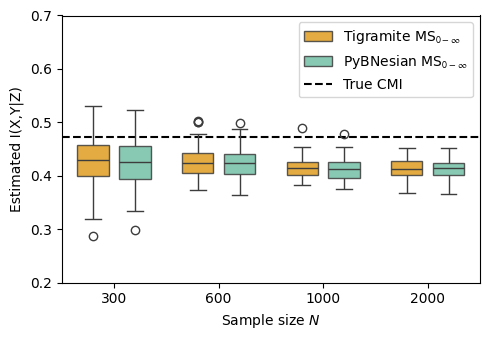

In [7]:
n_trials = 100
mi_pbn = []
mi_tgm = []
tgm_cmi = CMIknnMixed(knn=0.1, estimator='MSinf', transform='ranks', knn_type='local')

for seed, num_samples in tenumerate([300, 600, 1000, 2000]):
    acc_pbn = []
    acc_tgm = []
    for _ in range(n_trials):
        df, type_array, info, name, xyz = mi_multivar_mixture(n=num_samples)
        for i in range(len(df.columns)):
            if i == 2:
                df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')
        x = str(df.columns[0])
        y = str(df.columns[1])
        z = [str(x) for x in df.columns[2:]]
        categorical_df = df.select_dtypes(include=['category'])

        # Count frequency of each unique configuration
        min_cluster_size = categorical_df.value_counts().min()


        pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=max(1, int(min_cluster_size*0.1)), scaling="normalized_rank", adaptive_k=True)
        acc_pbn.append(pbn_knncmi.mi(x, y, z))

        for i in range(len(df.columns)):
            if i == 2:
                df.iloc[:, i] = df.iloc[:, i].cat.codes.astype(np.int64)
        array = df.values.T
        data_type=np.repeat(np.array([1* (df.dtypes== 'int64')]).T, len(df), axis=1)
        xyz=np.array([0, 1] + [2]*(len(df.columns) - 2))
     
        acc_tgm.append(tgm_cmi.get_dependence_measure(array=array, xyz=xyz, data_type=data_type))
    mi_pbn.append(acc_pbn)
    mi_tgm.append(acc_tgm)

num_groups = len(mi_tgm)
positions_tgm = np.arange(num_groups) - 0.2
positions_pbn = np.arange(num_groups) + 0.2

plt.figure(figsize=(5, 3.5))

# Plot each group side by side
sns.boxplot(data=mi_tgm, positions=positions_tgm, width=0.3, color='orange', label='Tigramite MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
sns.boxplot(data=mi_pbn, positions=positions_pbn, width=0.3, color='mediumaquamarine', label='PyBNesian MS$_{\mathcal{0-\infty}}$', boxprops=dict(alpha=.85))
plt.axhline(y=info, color='black', linestyle='--', label = 'True CMI', zorder=-1)

plt.xlabel("Sample size $N$", fontsize=10)
plt.ylabel("Estimated I(X,Y|Z)", fontsize=10)
plt.xticks(np.arange(num_groups), [300, 600, 1000, 2000])
plt.ylim((0.2, 0.7))
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig('./results/synthetic/CMI4.eps', format='eps', bbox_inches='tight')

#### Gamma approximation of pvalues

In [8]:
pvalues_pbn_gamma = []
pvalues_pbn = []
pvalues_tgm = []
repetitions = 25

def generate_conditionally_dependent_xy(N=1000, seed=None):
    rng = np.random.default_rng(seed)

    Z = rng.binomial(n=1, p=0.5, size=N)
    
    # Y depends on Z
    logits = -1 + 2 *Z   # Makes Y more likely when Z=1
    probs = expit(logits)
    Y = rng.binomial(n=1, p=probs)
    
    # X depends on both Y and Z, to induce conditional dependence
    # But noise makes it non-trivial
    X = rng.normal(loc=Y +  0.8*Z, scale=5, size=N)
    return X, Y, Z

X, Y, Z = generate_conditionally_dependent_xy(1000, seed=42)
df = pd.DataFrame([X, Y, Z]).T
for i in range(len(df.columns)):
    if i > 0:
        df.iloc[:, i] = df.iloc[:, i].astype(str).astype('category')

    
x = str(df.columns[0])
y = str(df.columns[1])
z = [str(x) for x in df.columns[2:]]

for seed, num_samples in tenumerate([800, 700, 600, 500, 400, 300, 200, 100, 80, 60, 40, 20, 10]):
    
    acc_list = []
    for i in range(repetitions):
        pbn_knncmi_gamma = pbn.MixedKMutualInformation(df=df, k=len(df)//10, scaling="normalized_rank", adaptive_k=True, shuffle_neighbors=5, samples=num_samples, gamma_approx=True, seed=42+777*i)
        acc_list.append(pbn_knncmi_gamma.pvalue(x, y))
    pvalues_pbn_gamma.append(acc_list)

    acc_list = []
    for i in range(repetitions):
        pbn_knncmi = pbn.MixedKMutualInformation(df=df, k=len(df)//10, scaling="normalized_rank", adaptive_k=True, shuffle_neighbors=5, samples=num_samples, gamma_approx=False, seed=42+777*i)
        acc_list.append(pbn_knncmi.pvalue(x, y))
    pvalues_pbn.append(acc_list)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [09:48<00:00, 45.29s/it]


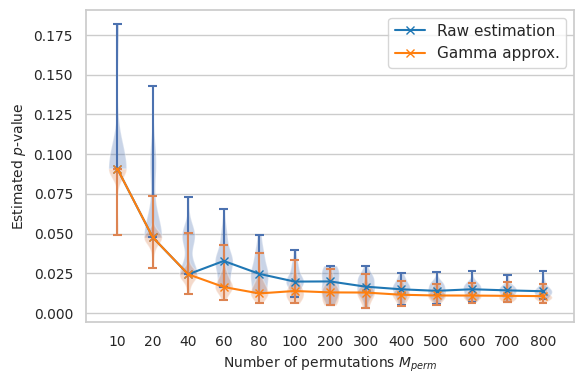

In [15]:
sns.set_theme()
sns.set_style("whitegrid")
fig = plt.figure(figsize=(6, 4))

# --- violin plots ---
vp_tgm = plt.violinplot(pvalues_pbn[::-1], positions=np.arange(13), widths=0.5)
vp_pbn = plt.violinplot(pvalues_pbn_gamma[::-1], positions=np.arange(13), widths=0.5)

# --- median lines ---
plt.plot(np.arange(13), [np.median(vals) for vals in pvalues_pbn][::-1],
         marker='x', color=u'#1f77b4', label='Raw estimation')
plt.plot(np.arange(13), [np.median(vals) for vals in pvalues_pbn_gamma][::-1],
         marker='x', color=u'#ff7f0e', label='Gamma approx.')


# --- labels ---
plt.xlabel("Number of permutations $M_{perm}$", fontsize=10)
plt.ylabel("Estimated $p$-value", fontsize=10)
plt.xticks(np.arange(13), [800, 700, 600, 500, 400, 300, 200, 100, 80, 60, 40, 20, 10][::-1], fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.tight_layout()
plt.grid(False, axis='x')
plt.savefig('./results/synthetic/pvalues.tiff', format = 'TIFF', bbox_inches='tight')
plt.savefig('./results/synthetic/pvalues.png', bbox_inches='tight')

In [16]:
def mult(n, r, p):
    return np.exp(
        r * np.log(p) + (n - r) * np.log(1 - p)
        - gammaln(r + 1) - gammaln(n - r + 1) + gammaln(n + 2)
    )

def rrisk(bound, pparms, sig_level=0.05):
    """
    Resampling risk for permutation test (type='p' only).

    Parameters:
        bound: dict with keys 'N', 'S', 'p.value', 'Kstar'
        pparms: list or array of p values to test
        sig_level: significance threshold

    Returns:
        dict with 'check' and 'rr'
    """
    d = bound
    nout = len(pparms)

    rr = np.full(nout, np.nan)
    check = np.full(nout, np.nan)

    N = np.array(d['N'])
    S = np.array(d['S'])
    p_values = np.array(d['p.value'])
    Kstar = np.array(d['Kstar'])

    for i in range(nout):
        p = pparms[i]

        if p <= sig_level:
            index = p_values > sig_level
        else:
            index = p_values <= sig_level

        rr[i] = np.sum(Kstar[index] * mult(N[index], S[index], p))
        check[i] = np.sum(Kstar * mult(N, S, p))

    return {"check": check, "rr": rr}

In [17]:
pparms_pbn = np.median(pvalues_pbn, axis=1)
pparms_pbn_gamma = np.median(pvalues_pbn_gamma, axis=1)
rrisk_pbn = []
rrisk_pbn_gamma = []
for i, num_samples in enumerate([800, 700, 600, 500, 400, 300, 200, 100, 80, 60, 40, 20, 10]):
    bound = {
    "N": np.array([num_samples]*(num_samples+1)),
    "S": np.arange(0, num_samples+1),
    "p.value": (np.arange(0, num_samples+1) + 1) / (num_samples+1),
    "Kstar": np.full(num_samples+1, 1 / num_samples+1)
}
    rrisk_pbn.append(rrisk(bound, [pparms_pbn[i]])['rr'])
    rrisk_pbn_gamma.append(rrisk(bound, [pparms_pbn_gamma[i]])['rr'])
rrisk_pbn = np.array(rrisk_pbn).ravel()
rrisk_pbn_gamma = np.array(rrisk_pbn_gamma).ravel()

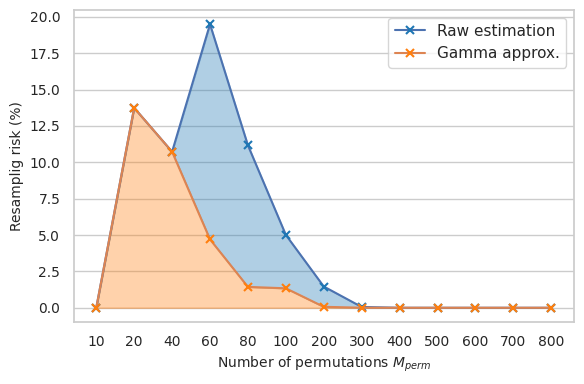

In [18]:
fig = plt.figure(figsize=(6, 4))
sns.lineplot(rrisk_pbn[::-1], label='Raw estimation', marker='x', markeredgecolor=u'#1f77b4', markeredgewidth=1.5, markersize=6 )
sns.lineplot(rrisk_pbn_gamma[::-1], label='Gamma approx.', marker='x',markeredgecolor=u'#ff7f0e', markeredgewidth=1.5, markersize=6 )
plt.xticks(np.arange(13), [800, 700, 600, 500, 400, 300, 200, 100, 80, 60, 40, 20, 10][::-1], fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Number of permutations $M_{perm}$", fontsize=10)
plt.ylabel('Resamplig risk (%)', fontsize=10)
plt.grid(False, axis='x')
plt.fill_between(
        np.arange(13),
        rrisk_pbn_gamma[::-1],
        rrisk_pbn[::-1],
        color=u'#1f77b4',
        alpha=0.35,
    )
plt.fill_between(
        np.arange(13),
        np.zeros(13),
        rrisk_pbn_gamma[::-1],
        color=u'#ff7f0e',
        alpha=0.35,
    )
plt.tight_layout()
plt.savefig('./results/synthetic/rrisk.tiff', format='TIFF', bbox_inches='tight')
plt.savefig('./results/synthetic/rrisk.png', bbox_inches='tight')
